# &#x1F4D1; &nbsp;  Digit Recognition Models

## Style, Links and Libraries
[`R interface to Keras`](https://tensorflow.rstudio.com/keras/)

[`Package "keras"`](https://cran.r-project.org/web/packages/keras/keras.pdf)

[`Deep Learning with R. François Chollet, J.J. Allaire`](https://github.com/jjallaire/deep-learning-with-r-notebooks)

In [30]:
library(IRdisplay)
library(repr)
library(tensorflow)
library(keras)
library(imager)
library(R6)
library(caret)

In [3]:
display_html("<style> 
@import url('https://fonts.googleapis.com/css?family=Orbitron|Roboto');
body {background-color: gainsboro;} 
a {color: #37c9e1; font-family: 'Roboto';} 
h1 {color: #37c9e1; font-family: 'Orbitron'; text-shadow: 4px 4px 4px #ccc;} 
h2, h3 {color: slategray; font-family: 'Orbitron'; text-shadow: 4px 4px 4px #ccc;}
h4 {color: #818286; font-family: 'Roboto';}
span {text-shadow: 4px 4px 4px #ccc;}
div.output_prompt, div.output_area pre {color: slategray;}
div.input_prompt, div.output_subarea {color: #37c9e1;}      
div.output_stderr pre {background-color: gainsboro;}  
div.output_stderr {background-color: slategrey;} 
</style>")

## Dataset

In [20]:
df_train <- read.csv("kaggle_digits_train.csv")
df_test  <- read.csv("kaggle_digits_test.csv")

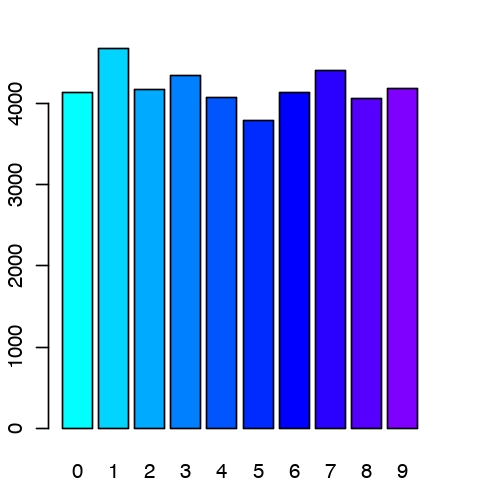

In [21]:
options(repr.plot.width=4,repr.plot.height=4)
par(mar=c(2,2,2,2))
df_train[,1] %>% 
    table() %>% 
    barplot(col=rainbow(10,start=0.5,end=0.75))

In [22]:
n <- nrow(df_train)
df_train <- df_train[sample(n),]

In [23]:
train_labels <- keras::to_categorical(as.matrix(df_train[,1]), num_classes=10)
train_images <- as.matrix(df_train[,-1]) / 255
test_images <- as.matrix(df_test) / 255
dim(train_images); dim(test_images); dim(train_labels)

[1] 42000   784

[1] 28000   784

[1] 42000    10

In [24]:
train_images[15:20,15:20]

,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19
3186,0,0,0,0,0,0
22857,0,0,0,0,0,0
38548,0,0,0,0,0,0
30399,0,0,0,0,0,0
33861,0,0,0,0,0,0
31682,0,0,0,0,0,0


[1] 28 28

[1] 1 0 0 0 0 0 0 0 0 0

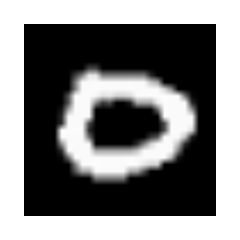

In [25]:
options(repr.plot.width=2,repr.plot.height=2)
par(mar=c(1,1,1,1))
image_example <- train_images[1000,]
image_example <- array_reshape(image_example,c(28,28))
dim(image_example)
train_labels[1000,]
plot(as.raster(image_example))

In [26]:
train_indices <- 1:round(0.7 * n)
valid_indices <- (round(0.7 * n) + 1):round(0.85 * n)
test_indices <- (round(0.85 * n) + 1):n

In [27]:
x_train <- train_images[train_indices,]
y_train <- train_labels[train_indices,]
x_valid <- train_images[valid_indices,]
y_valid <- train_labels[valid_indices,]
x_test <- train_images[test_indices,]
y_test <- train_labels[test_indices,]

In [28]:
dim(x_train); dim(x_valid); dim(x_test); dim(y_train); dim(y_valid); dim(y_test)

[1] 29400   784

[1] 6300  784

[1] 6300  784

[1] 29400    10

[1] 6300   10

[1] 6300   10

## Neural Network Models

In [13]:
# CNN
cnn_model <- keras_model_sequential()

cnn_model %>% 
  
layer_conv_2d(input_shape=c(28,28,1),
              filter=28,kernel_size=c(5,5),padding="same") %>%  
layer_activation_leaky_relu(alpha=0.02) %>%  
  
layer_max_pooling_2d(pool_size=c(2,2)) %>%  
layer_dropout(0.25) %>%

layer_conv_2d(filter=128,kernel_size=c(5,5),padding="same") %>% 
layer_activation_leaky_relu(alpha=0.02) %>%  

layer_max_pooling_2d(strides=c(2,2)) %>%  
layer_dropout(0.25) %>%

layer_global_max_pooling_2d() %>%  

layer_dense(1024) %>%  
layer_activation_leaky_relu(alpha=0.02) %>% 
layer_dropout(0.4) %>%  
  
layer_dense(10) %>%    
layer_activation("softmax")

In [14]:
cnn_model %>%
  compile(loss="categorical_crossentropy",optimizer="nadam",metrics="accuracy")

In [15]:
summary(cnn_model)

________________________________________________________________________________
Layer (type)                        Output Shape                    Param #     
conv2d_1 (Conv2D)                   (None, 28, 28, 28)              728         
________________________________________________________________________________
leaky_re_lu_1 (LeakyReLU)           (None, 28, 28, 28)              0           
________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)      (None, 14, 14, 28)              0           
________________________________________________________________________________
dropout_1 (Dropout)                 (None, 14, 14, 28)              0           
________________________________________________________________________________
conv2d_2 (Conv2D)                   (None, 14, 14, 128)             89728       
________________________________________________________________________________
leaky_re_lu_2 (LeakyReLU)   

In [16]:
cnn_fit <- cnn_model %>%
  fit(x=array_reshape(x_train,c(dim(x_train)[1],28,28,1)),
      y=y_train,
      validation_data=list(array_reshape(x_valid,c(dim(x_valid)[1],28,28,1)),y_valid),
      shuffle=T,
      batch_size=128,
      epochs=100,
      callbacks=list(callback_model_checkpoint("cnn_best_digits.h5",save_best_only=T),
                     callback_reduce_lr_on_plateau(monitor="val_loss",factor=0.2)))

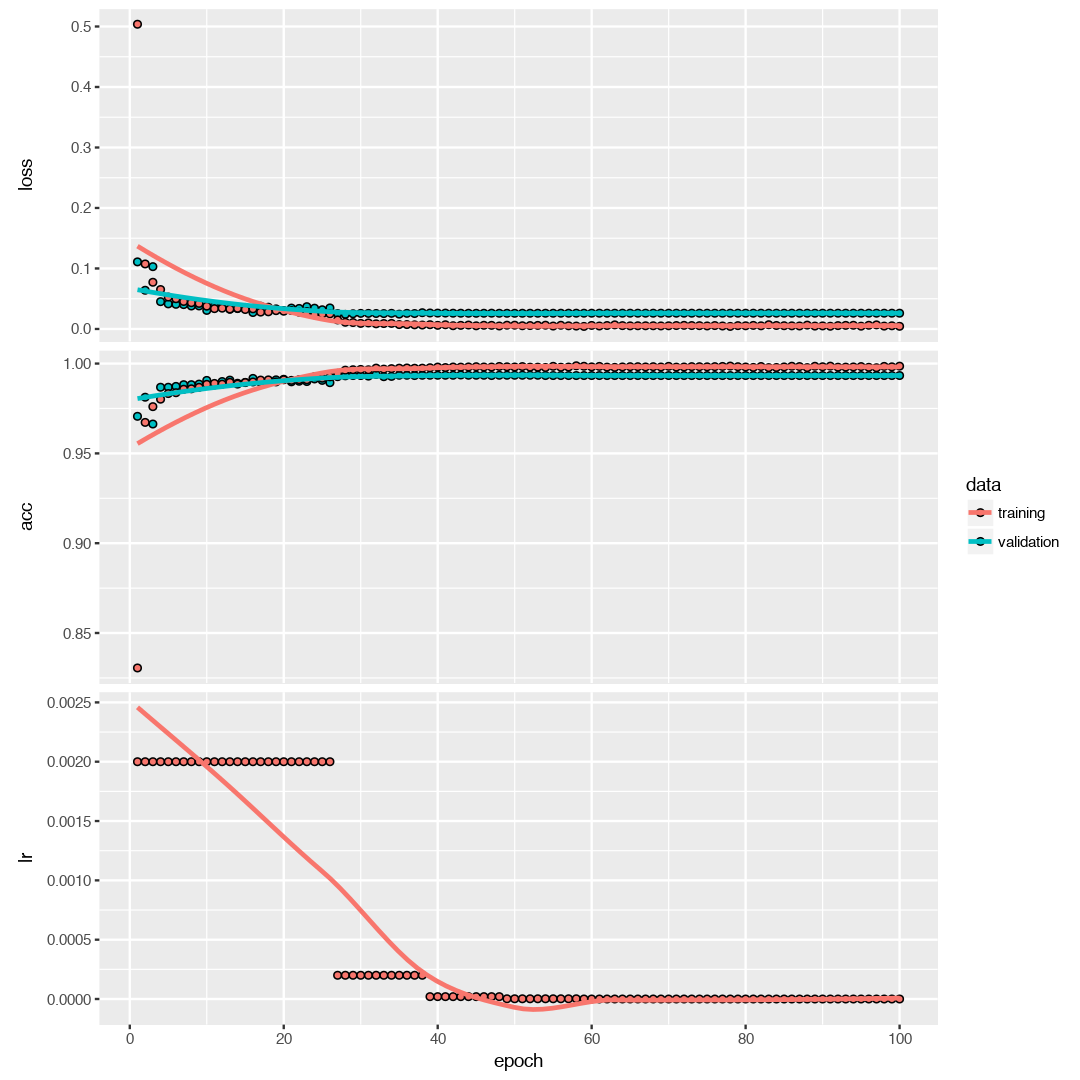

In [17]:
options(warn=-1,repr.plot.width=9,repr.plot.height=9)
plot(cnn_fit)

In [18]:
cnn_fit_df <- as.data.frame(cnn_fit)
cnn_fit_df[81:100,]

,epoch,value,metric,data
81,81,0.02608398,loss,validation
82,82,0.02608398,loss,validation
83,83,0.02608397,loss,validation
84,84,0.02608397,loss,validation
85,85,0.02608397,loss,validation
86,86,0.02608398,loss,validation
87,87,0.02608398,loss,validation
88,88,0.02608398,loss,validation
89,89,0.02608398,loss,validation
90,90,0.02608398,loss,validation


In [136]:
load_model_weights_hdf5(cnn_model,"cnn_best_digits.h5")

In [19]:
cnn_score <- cnn_model %>% 
    evaluate(array_reshape(x_test,c(dim(x_test)[1],28,28,1)),y_test)
cnn_score

$loss
[1] 0.02012723

$acc
[1] 0.9936508

In [148]:
cnn_predict <- cnn_model %>% 
    predict_classes(array_reshape(test_images,c(dim(test_images)[1],28,28,1)),
                    batch_size=128)

cnn_submission <- data.frame(ImageId=1:dim(test_images)[1],Label=cnn_predict)

write.csv(cnn_submission, file="cnn_submission_digits.csv", row.names=F)

In [149]:
real_test_labels <- c(2, 0, 9, 0, 3, 7, 0, 3, 0, 3,
                      5, 7, 4, 0, 4, 3, 3, 1, 9, 0,
                      9, 1, 1, 5, 7, 4, 2, 7, 4, 7,
                      7, 5, 4, 2, 6, 2, 5, 5, 1, 6,
                      7, 7, 4, 9, 8, 7, 8, 2, 6, 7,
                      6, 8, 8, 3, 8, 2, 1, 2, 2, 0,
                      4, 1, 7, 0, 0, 0, 1, 9, 0, 1,
                      6, 5, 8, 8, 2, 8, 9, 9, 2, 3,
                      5, 4, 1, 0, 9, 2, 4, 3, 6, 7,
                      2, 0, 6, 6, 1, 4, 3, 9, 7, 4,
                      0, 9, 2, 0, 7, 3, 0, 5, 0, 8,
                      0, 0, 4, 7, 1, 7, 1, 1, 3, 3,
                      3, 7, 2, 8, 6, 3, 8, 7, 7, 4,
                      3, 5, 4, 0, 0, 0, 3, 1, 3, 6,
                      4, 3, 4, 5, 5, 8, 7, 4, 2, 8,
                      4, 3, 5, 6, 5, 3, 7, 5, 7, 8,
                      3, 0, 4, 5, 1, 3, 7, 6, 3, 0,
                      2, 7, 8, 6, 1, 3, 7, 4, 1, 2,
                      4, 8, 5, 2, 4, 9, 2, 1, 6, 0,
                      6, 1, 4, 9, 6, 0, 9, 7, 6, 9,
                      1, 9, 0, 9, 9, 0, 8, 4, 6, 2,
                      0, 9, 3, 6, 3, 2, 1, 6, 3, 4,
                      2, 3, 1, 2, 2, 0, 4, 6, 1, 0,
                      0, 4, 9, 1, 7, 3, 2, 3, 8, 6,
                      8, 6, 2, 8, 5, 5, 4, 8, 3, 5,
                      9, 7, 1, 3, 8, 4, 5, 1, 4, 5,
                      6, 3, 3, 5, 7, 0, 6, 8, 3, 1,
                      6, 0, 6, 3, 9, 5, 1, 5, 8, 4,
                      0, 9, 2, 0, 5, 3, 7, 1, 9, 9,
                      5, 7, 7, 9, 9, 6, 3, 0, 3, 3)

In [150]:
sum(cnn_predict[1:300] == real_test_labels) / 300

[1] 0.9866667

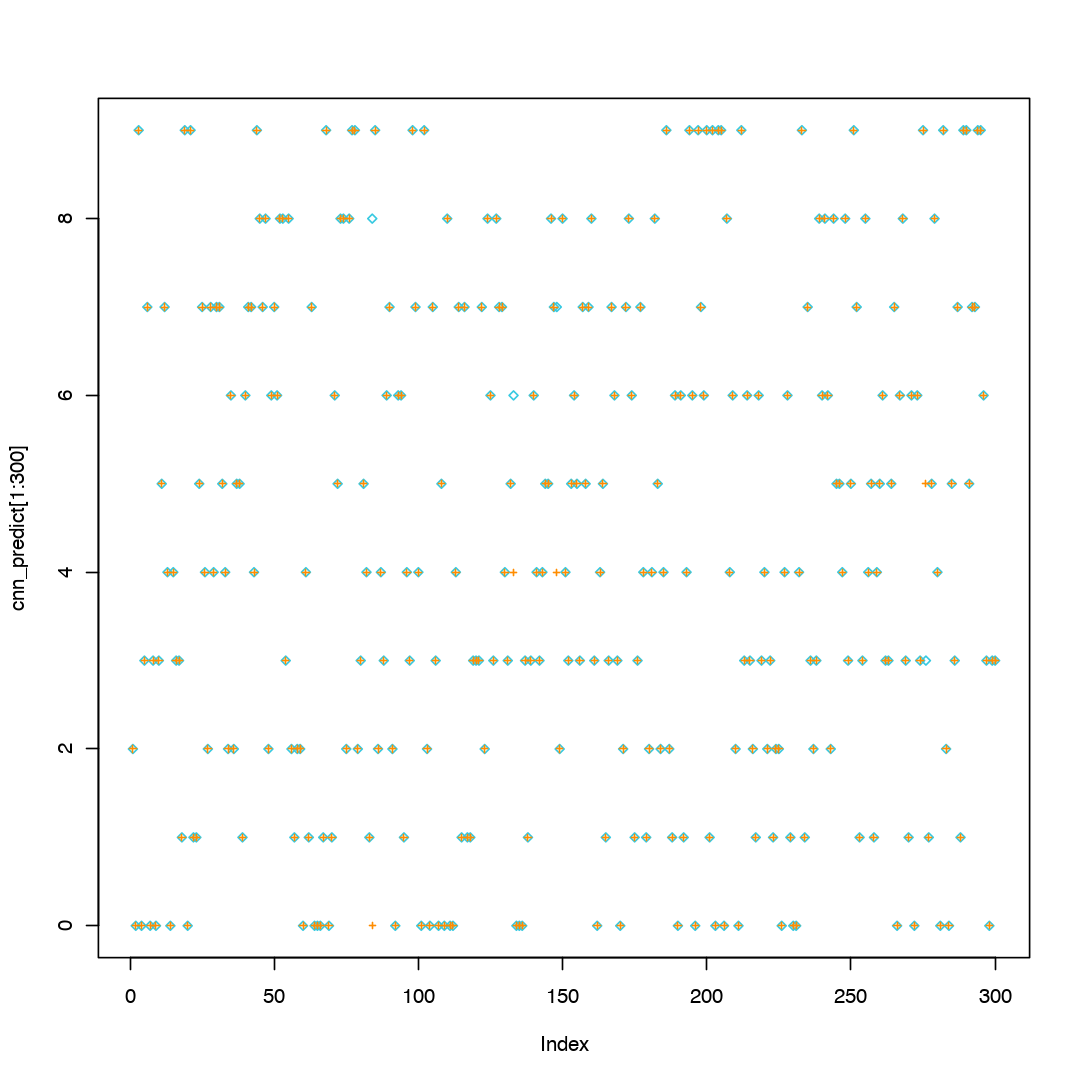

In [165]:
plot(cnn_predict[1:300],pch=5,cex=0.7,col='#37c9e1')
points(real_test_labels,pch=3,cex=0.5,col='darkorange')

In [189]:
generated_images <- image_data_generator(
    featurewise_center = TRUE,
    featurewise_std_normalization = TRUE,
    rotation_range = 20,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    horizontal_flip = TRUE
    )

generated_images %>% 
    fit_image_data_generator(array_reshape(x_train,c(dim(x_train)[1],28,28,1)))

In [190]:
dg_cnn_fit <- cnn_model %>%
    fit_generator(flow_images_from_data(array_reshape(x_train,c(dim(x_train)[1],28,28,1)),
                                        y_train,
                                        generated_images,
                                        batch_size=128), 
                  steps_per_epoch=1000, 
                  epochs=50,
                  validation_data=list(array_reshape(x_valid,c(dim(x_valid)[1],28,28,1)),y_valid),
                  callbacks=list(callback_model_checkpoint("cnn_best_digits.h5",save_best_only=T),
                                 callback_reduce_lr_on_plateau(monitor="val_loss",factor=0.5)))

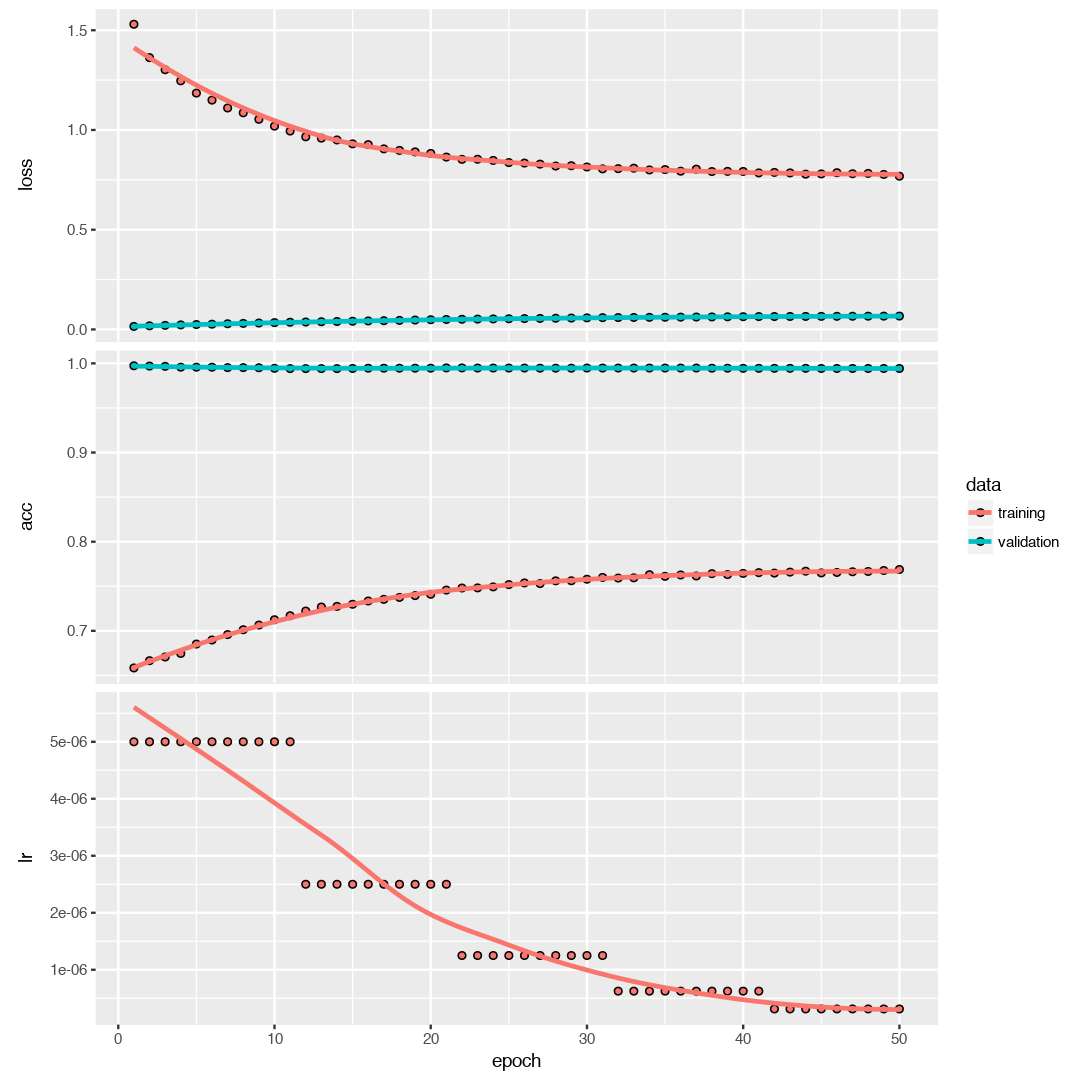

In [191]:
options(warn=-1,repr.plot.width=9,repr.plot.height=9)
plot(dg_cnn_fit)

In [192]:
load_model_weights_hdf5(cnn_model,"cnn_best_digits.h5")

In [193]:
dg_cnn_score <- cnn_model %>% 
    evaluate(array_reshape(x_test,c(dim(x_test)[1],28,28,1)),y_test)
dg_cnn_score

$loss
[1] 0.01364811

$acc
[1] 0.9971429

In [96]:
# MLP
mlp_model <- keras_model_sequential()

mlp_model %>%  

layer_dense(1568, input_shape=c(784)) %>%  
layer_activation("relu") %>%  
layer_dropout(0.2) %>% 

layer_dense(392) %>%  
layer_activation("relu") %>%  
layer_dropout(0.2) %>%

layer_dense(128) %>%  
layer_activation("relu") %>%  
layer_dropout(0.2) %>%
  
layer_dense(10) %>%    
layer_activation("softmax")

In [97]:
mlp_model %>%
  compile(loss="categorical_crossentropy",optimizer="nadam",metrics="accuracy")

In [98]:
summary(mlp_model)

________________________________________________________________________________
Layer (type)                        Output Shape                    Param #     
dense_9 (Dense)                     (None, 1568)                    1230880     
________________________________________________________________________________
activation_9 (Activation)           (None, 1568)                    0           
________________________________________________________________________________
dropout_13 (Dropout)                (None, 1568)                    0           
________________________________________________________________________________
dense_10 (Dense)                    (None, 392)                     615048      
________________________________________________________________________________
activation_10 (Activation)          (None, 392)                     0           
________________________________________________________________________________
dropout_14 (Dropout)        

In [99]:
mlp_fit <- mlp_model %>%
  fit(x=x_train,
      y=y_train,
      validation_data=list(x_valid,y_valid),
      shuffle=T,
      batch_size=128,
      epochs=50,
      callbacks=list(callback_model_checkpoint("mlp_best_digits.h5",save_best_only=T),
                     callback_reduce_lr_on_plateau(monitor="val_loss",factor=0.05)))

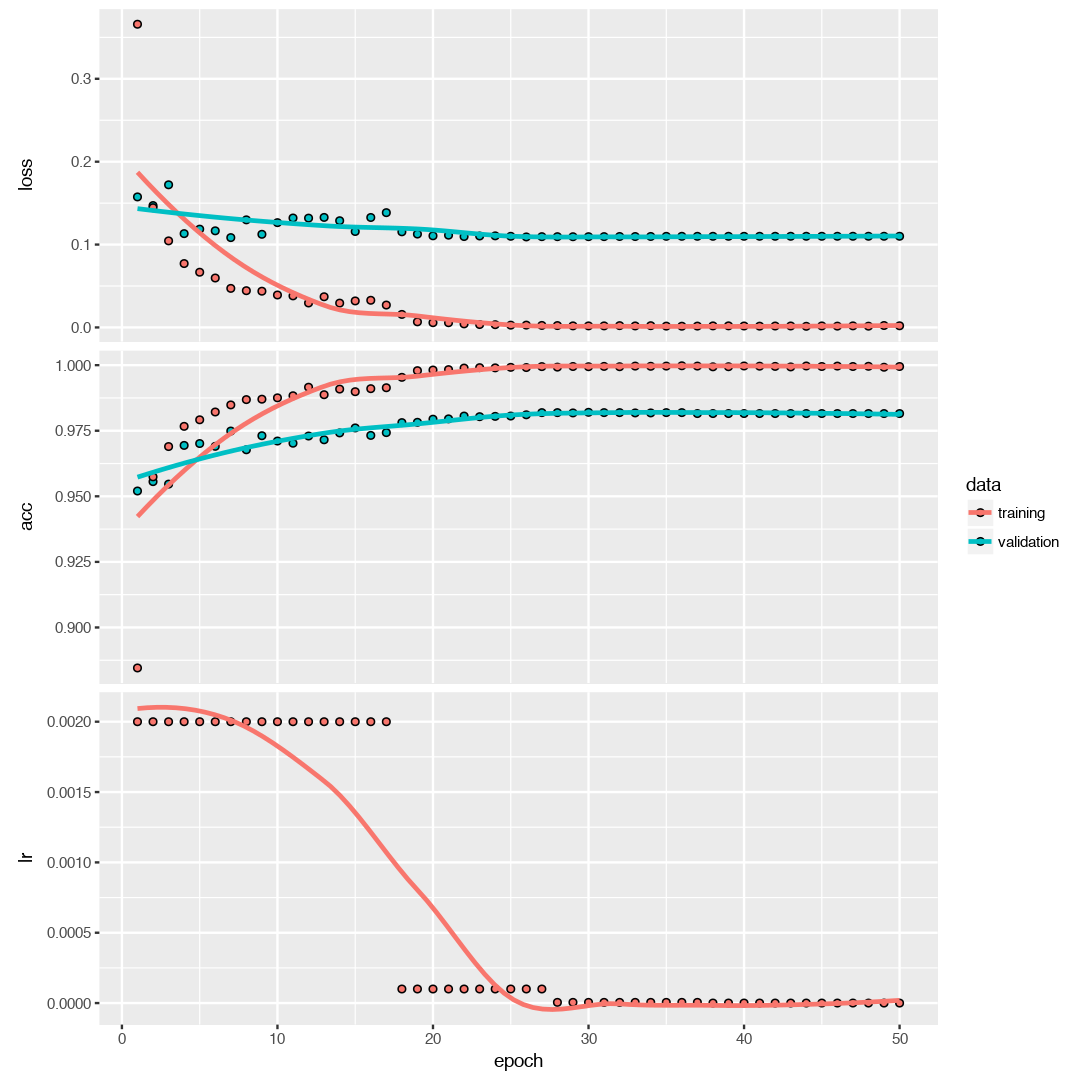

In [100]:
options(warn=-1,repr.plot.width=9,repr.plot.height=9)
plot(mlp_fit)

In [101]:
mlp_fit_df <- as.data.frame(mlp_fit)
mlp_fit_df[81:100,]

,epoch,value,metric,data
81,31,0.9819048,acc,validation
82,32,0.9819048,acc,validation
83,33,0.9817857,acc,validation
84,34,0.9817857,acc,validation
85,35,0.9819048,acc,validation
86,36,0.9819048,acc,validation
87,37,0.9815476,acc,validation
88,38,0.9815476,acc,validation
89,39,0.9815476,acc,validation
90,40,0.9815476,acc,validation


In [102]:
load_model_weights_hdf5(mlp_model,"mlp_best_digits.h5")

In [103]:
mlp_score <- mlp_model %>% 
    evaluate(x_test,y_test)
mlp_score

$loss
[1] 0.09521187

$acc
[1] 0.9765476

In [28]:
# RNN
rnn_model <- keras_model_sequential()

rnn_model %>%  

layer_lstm(196, return_sequences=T, input_shape=c(1,784)) %>%  
layer_lstm(196, return_sequences=T) %>%

layer_lstm(784) %>%  
# layer_dropout(0.2) %>%

layer_dense(10) %>%    
layer_activation("softmax")

In [29]:
rnn_model %>%
  compile(loss="categorical_crossentropy",optimizer="nadam",metrics="accuracy")

In [30]:
summary(rnn_model)

________________________________________________________________________________
Layer (type)                        Output Shape                    Param #     
lstm_4 (LSTM)                       (None, 1, 196)                  769104      
________________________________________________________________________________
lstm_5 (LSTM)                       (None, 1, 196)                  308112      
________________________________________________________________________________
lstm_6 (LSTM)                       (None, 784)                     3076416     
________________________________________________________________________________
dense_2 (Dense)                     (None, 10)                      7850        
________________________________________________________________________________
activation_2 (Activation)           (None, 10)                      0           
Total params: 4,161,482
Trainable params: 4,161,482
Non-trainable params: 0
_________________________________

In [31]:
rnn_fit <- rnn_model %>%
  fit(
    x=array_reshape(x_train,c(dim(x_train)[1],1,784)),
    y=y_train,
    shuffle=T,
    batch_size=128,
    validation_data=list(array_reshape(x_valid,c(dim(x_valid)[1],1,784)),y_valid),
    epochs=30,
    callbacks=list(callback_model_checkpoint("rnn_best_digits.h5",save_best_only=T),
                   callback_reduce_lr_on_plateau(monitor="val_loss",factor=0.1))
  )

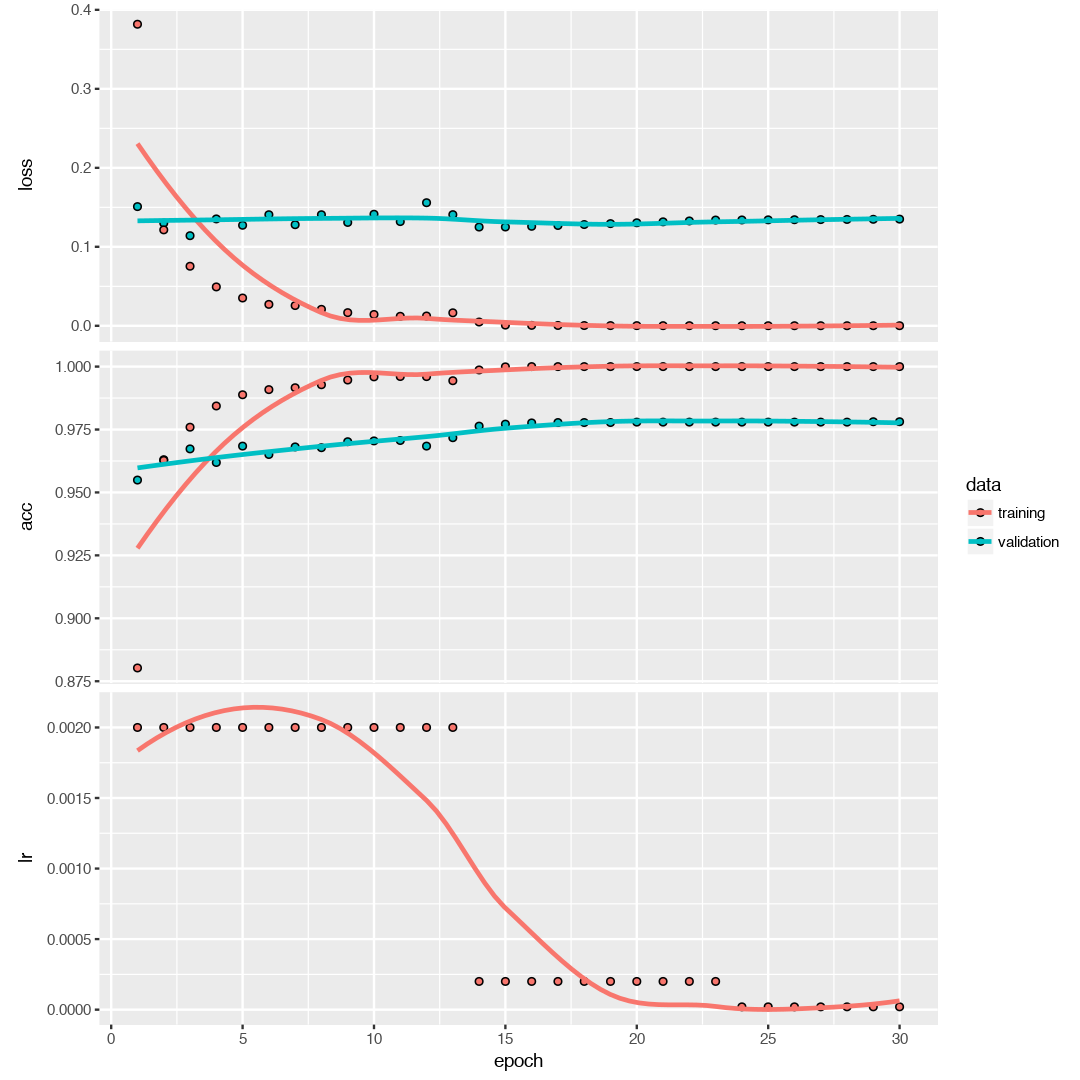

In [32]:
options(warn=-1,repr.plot.width=9,repr.plot.height=9)
plot(rnn_fit)

In [33]:
rnn_fit_df <- as.data.frame(rnn_fit)
rnn_fit_df[31:60,1:4]

,epoch,value,metric,data
31,1,0.9549206,acc,validation
32,2,0.9630159,acc,validation
33,3,0.9673016,acc,validation
34,4,0.9619048,acc,validation
35,5,0.9684127,acc,validation
36,6,0.9650794,acc,validation
37,7,0.9680952,acc,validation
38,8,0.9677778,acc,validation
39,9,0.9701587,acc,validation
40,10,0.9704762,acc,validation


In [34]:
load_model_weights_hdf5(rnn_model,"rnn_best_digits.h5")

In [35]:
rnn_score <- rnn_model %>% 
    evaluate(array_reshape(x_test,c(dim(x_test)[1],1,784)),y_test)
rnn_score

$loss
[1] 0.1176296

$acc
[1] 0.9631746

## Classifiers

In [36]:
# install.packages('randomForest')

In [31]:
paste(names(getModelInfo()), collapse=',  ')

[1] "ada,  AdaBag,  AdaBoost.M1,  adaboost,  amdai,  ANFIS,  avNNet,  awnb,  awtan,  bag,  bagEarth,  bagEarthGCV,  bagFDA,  bagFDAGCV,  bam,  bartMachine,  bayesglm,  binda,  blackboost,  blasso,  blassoAveraged,  bridge,  brnn,  BstLm,  bstSm,  bstTree,  C5.0,  C5.0Cost,  C5.0Rules,  C5.0Tree,  cforest,  chaid,  CSimca,  ctree,  ctree2,  cubist,  dda,  deepboost,  DENFIS,  dnn,  dwdLinear,  dwdPoly,  dwdRadial,  earth,  elm,  enet,  evtree,  extraTrees,  fda,  FH.GBML,  FIR.DM,  foba,  FRBCS.CHI,  FRBCS.W,  FS.HGD,  gam,  gamboost,  gamLoess,  gamSpline,  gaussprLinear,  gaussprPoly,  gaussprRadial,  gbm_h2o,  gbm,  gcvEarth,  GFS.FR.MOGUL,  GFS.LT.RS,  GFS.THRIFT,  glm.nb,  glm,  glmboost,  glmnet_h2o,  glmnet,  glmStepAIC,  gpls,  hda,  hdda,  hdrda,  HYFIS,  icr,  J48,  JRip,  kernelpls,  kknn,  knn,  krlsPoly,  krlsRadial,  lars,  lars2,  lasso,  lda,  lda2,  leapBackward,  leapForward,  leapSeq,  Linda,  lm,  lmStepAIC,  LMT,  loclda,  logicBag,  LogitBoost,  logreg,  lssvmLinear,  lssvmPoly,  lssvmRadial,  lvq,  M5,  M5Rules,  manb,  mda,  Mlda,  mlp,  mlpKerasDecay,  mlpKerasDecayCost,  mlpKerasDropout,  mlpKerasDropoutCost,  mlpML,  mlpSGD,  mlpWeightDecay,  mlpWeightDecayML,  monmlp,  msaenet,  multinom,  mxnet,  mxnetAdam,  naive_bayes,  nb,  nbDiscrete,  nbSearch,  neuralnet,  nnet,  nnls,  nodeHarvest,  null,  OneR,  ordinalNet,  ORFlog,  ORFpls,  ORFridge,  ORFsvm,  ownn,  pam,  parRF,  PART,  partDSA,  pcaNNet,  pcr,  pda,  pda2,  penalized,  PenalizedLDA,  plr,  pls,  plsRglm,  polr,  ppr,  PRIM,  protoclass,  qda,  QdaCov,  qrf,  qrnn,  randomGLM,  ranger,  rbf,  rbfDDA,  Rborist,  rda,  regLogistic,  relaxo,  rf,  rFerns,  RFlda,  rfRules,  ridge,  rlda,  rlm,  rmda,  rocc,  rotationForest,  rotationForestCp,  rpart,  rpart1SE,  rpart2,  rpartCost,  rpartScore,  rqlasso,  rqnc,  RRF,  RRFglobal,  rrlda,  RSimca,  rvmLinear,  rvmPoly,  rvmRadial,  SBC,  sda,  sdwd,  simpls,  SLAVE,  slda,  smda,  snn,  sparseLDA,  spikeslab,  spls,  stepLDA,  stepQDA,  superpc,  svmBoundrangeString,  svmExpoString,  svmLinear,  svmLinear2,  svmLinear3,  svmLinearWeights,  svmLinearWeights2,  svmPoly,  svmRadial,  svmRadialCost,  svmRadialSigma,  svmRadialWeights,  svmSpectrumString,  tan,  tanSearch,  treebag,  vbmpRadial,  vglmAdjCat,  vglmContRatio,  vglmCumulative,  widekernelpls,  WM,  wsrf,  xgbDART,  xgbLinear,  xgbTree,  xyf"

In [74]:
train_row_numbers <- createDataPartition(df_train$label, p=0.8, list=FALSE)
train_data <- df_train[train_row_numbers,]
test_data <- df_train[-train_row_numbers,]
train_data$label <- as.factor(train_data$label)
levels(train_data$label) <- make.names(levels(factor(train_data$label)))
test_data$label <- as.factor(test_data$label)
levels(test_data$label) <- make.names(levels(factor(test_data$label)))

In [70]:
"
fit_control <- trainControl(
    method = 'cv',                   
    number = 5,                      
    savePredictions = 'final',       
    classProbs = T,                  
    summaryFunction=multiClassSummary
)"

In [80]:
fit_control <- trainControl(method="repeatedcv", number=10, repeats=3)
metric <- "Accuracy"
set.seed(9)
mtry <- sqrt(ncol(test_data)-1)
tune_grid <- expand.grid(.mtry=mtry)

In [81]:
rf_model <- train(
    label ~ ., 
    data=test_data, 
    method='rf', 
    metric=metric, 
    tuneGrid=tune_grid, 
    trControl=fit_control)
rf_model

Random Forest 

8398 samples
 784 predictor
  10 classes: 'X0', 'X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7', 'X8', 'X9' 

No pre-processing
Resampling: Cross-Validated (10 fold, repeated 3 times) 
Summary of sample sizes: 7558, 7557, 7559, 7559, 7557, 7559, ... 
Resampling results:

  Accuracy   Kappa    
  0.9496765  0.9440727

Tuning parameter 'mtry' was held constant at a value of 28

In [82]:
predictions <- predict(rf_model, newdata=test_data)

In [84]:
confusionMatrix(predictions, test_data$label)

Confusion Matrix and Statistics

          Reference
Prediction  X0  X1  X2  X3  X4  X5  X6  X7  X8  X9
        X0 843   0   0   0   0   0   0   0   0   0
        X1   0 921   0   0   0   0   0   0   0   0
        X2   0   0 834   0   0   0   0   0   0   0
        X3   0   0   0 841   0   0   0   0   0   0
        X4   0   0   0   0 843   0   0   0   0   0
        X5   0   0   0   0   0 773   0   0   0   0
        X6   0   0   0   0   0   0 832   0   0   0
        X7   0   0   0   0   0   0   0 861   0   0
        X8   0   0   0   0   0   0   0   0 821   0
        X9   0   0   0   0   0   0   0   0   0 829

Overall Statistics
                                     
               Accuracy : 1          
                 95% CI : (0.9996, 1)
    No Information Rate : 0.1097     
    P-Value [Acc > NIR] : < 2.2e-16  
                                     
                  Kappa : 1          
 Mcnemar's Test P-Value : NA         

Statistics by Class:

                     Class: X0 Class: X